In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

In [41]:
df = pd.read_csv('PenningtonGrass_handlable.csv', index_col = [0])

In [42]:
#replace NaN in label columns with 0
columns = ['cost','ease of use', 'effectiveness', 'efficiency']

for column in columns:
    df[column] = df[column].replace(np.nan, int(0))

# Sentiment Analysis

In [43]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = [None] * len(df)
index = -1
for sentence in df['review_lower'][0:99]:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
df['sentiment_m'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40
60
80


# Zero-Shot Classifier

In [46]:
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

In [47]:
# insert the labels you identified from above section
type = ['cost', 'efficiency', 'effectiveness', 'ease of use']

In [48]:
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(99):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0
20
40
60
80


# Sentiment Evaluation

In [49]:
def imputation1(list):
    i = []
    for prediction in list:
        if prediction == "Positive":
            i.append(1)
        elif prediction == "Neutral":
            i.append(0)
        else:
            i.append(-1)    
    return(i)

In [50]:
df['sentiment'] = imputation1(df['sentiment'])
df['sentiment_m'] = imputation1(df['sentiment_m'])

In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(df['sentiment'], df['sentiment_m']))

              precision    recall  f1-score   support

          -1       1.00      0.81      0.90       400
           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0

    accuracy                           0.81       400
   macro avg       0.33      0.27      0.30       400
weighted avg       1.00      0.81      0.90       400



# Zero-Shot Evaluation

In [53]:
def imputation(list):
    i = []
    for prediction in list:
        if prediction < 0.7:
            i.append(0)
        else:
            i.append(1)
    
    return(i)

In [54]:
df['cost_m'] = imputation(df['cost_m'])
df['efficiency_m'] = imputation(df['efficiency_m'])
df['effectiveness_m'] = imputation(df['effectiveness_m'])
df['ease of use_m'] = imputation(df['ease of use_m'])

In [55]:
print(classification_report(df['cost'], df['cost_m']))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       396
         1.0       0.10      0.75      0.17         4

    accuracy                           0.93       400
   macro avg       0.55      0.84      0.57       400
weighted avg       0.99      0.93      0.95       400



In [56]:
from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(df['cost'], df['cost_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8396


In [57]:
print(classification_report(df['efficiency'], df['efficiency_m']))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       369
         1.0       0.48      0.32      0.38        31

    accuracy                           0.92       400
   macro avg       0.71      0.65      0.67       400
weighted avg       0.91      0.92      0.91       400



In [58]:
ROC_AUC = roc_auc_score(df['efficiency'], df['efficiency_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.6464


In [59]:
print(classification_report(df['effectiveness'], df['effectiveness_m']))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.95       304
         1.0       0.99      0.71      0.82        96

    accuracy                           0.93       400
   macro avg       0.95      0.85      0.89       400
weighted avg       0.93      0.93      0.92       400



In [60]:
ROC_AUC = roc_auc_score(df['effectiveness'], df['effectiveness_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8525


In [61]:
print(classification_report(df['ease of use'], df['ease of use_m']))

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95       371
         1.0       0.46      0.72      0.56        29

    accuracy                           0.92       400
   macro avg       0.72      0.83      0.76       400
weighted avg       0.94      0.92      0.93       400



In [62]:
ROC_AUC = roc_auc_score(df['ease of use'], df['ease of use_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8284


# Compare Zero-Shot against a Naive Classifier

In [63]:
def naive(list):
    avg  = np.mean(list)

    if avg >= 0.5:
        i = 1
    else:
        i = 0

    return([i] * len(list))

In [64]:
df['naive_cost'] = naive(df['cost'])
df['naive_efficiency'] = naive(df['efficiency'])
df['naive_effectiveness'] = naive(df['effectiveness'])
df['naive_easeofuse'] = naive(df['ease of use'])

In [65]:
print(classification_report(df['cost'], df['naive_cost']))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       396
         1.0       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



In [66]:
print(classification_report(df['efficiency'], df['naive_efficiency']))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       369
         1.0       0.00      0.00      0.00        31

    accuracy                           0.92       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.85      0.92      0.89       400



In [67]:
print(classification_report(df['effectiveness'], df['naive_effectiveness']))

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86       304
         1.0       0.00      0.00      0.00        96

    accuracy                           0.76       400
   macro avg       0.38      0.50      0.43       400
weighted avg       0.58      0.76      0.66       400



In [68]:
print(classification_report(df['ease of use'], df['naive_easeofuse']))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       371
         1.0       0.00      0.00      0.00        29

    accuracy                           0.93       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.86      0.93      0.89       400



In [31]:
df.to_csv('PenningtonGrass_evaluation.csv')

# Visulization

In [69]:
report_sentiment = classification_report(df['sentiment'], df['sentiment_m'], output_dict=True)

In [110]:
def accuracy(type):
  report = classification_report(df[type], df[type+'_m'], output_dict=True)
  return (type, report['accuracy'])

In [112]:
def accuracy_matrix(type):
  report = classification_report(df[type], df[type+'_m'], output_dict=True)
  data= np.ones((100, 100))
  data[0:int(report_sentiment['accuracy']*100),0:int(report['accuracy']*100)] = 0.0 
  return data

In [125]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.ticker as mticker  
import matplotlib.patches as mpatches

Text(0.5, 0, 'cost accuracy')

Text(0, 0.5, 'sentiment accuracy')

Text(0, 0.5, 'sentiment accuracy')

Text(0.5, 0, 'ease of use accuracy')

Text(0.5, 0, 'effectiveness accuracy')

Text(0.5, 0, 'efficiency accuracy')

Text(40, 50, 'sentiment: 0.81')

Text(40, 50, 'sentiment: 0.81')

Text(40, 50, 'sentiment: 0.81')

Text(40, 50, 'sentiment: 0.81')

Text(40, 40, 'cost: 0.9275')

Text(40, 40, 'ease of use: 0.9175')

Text(40, 40, 'effectiveness: 0.9275')

Text(40, 40, 'efficiency: 0.92')

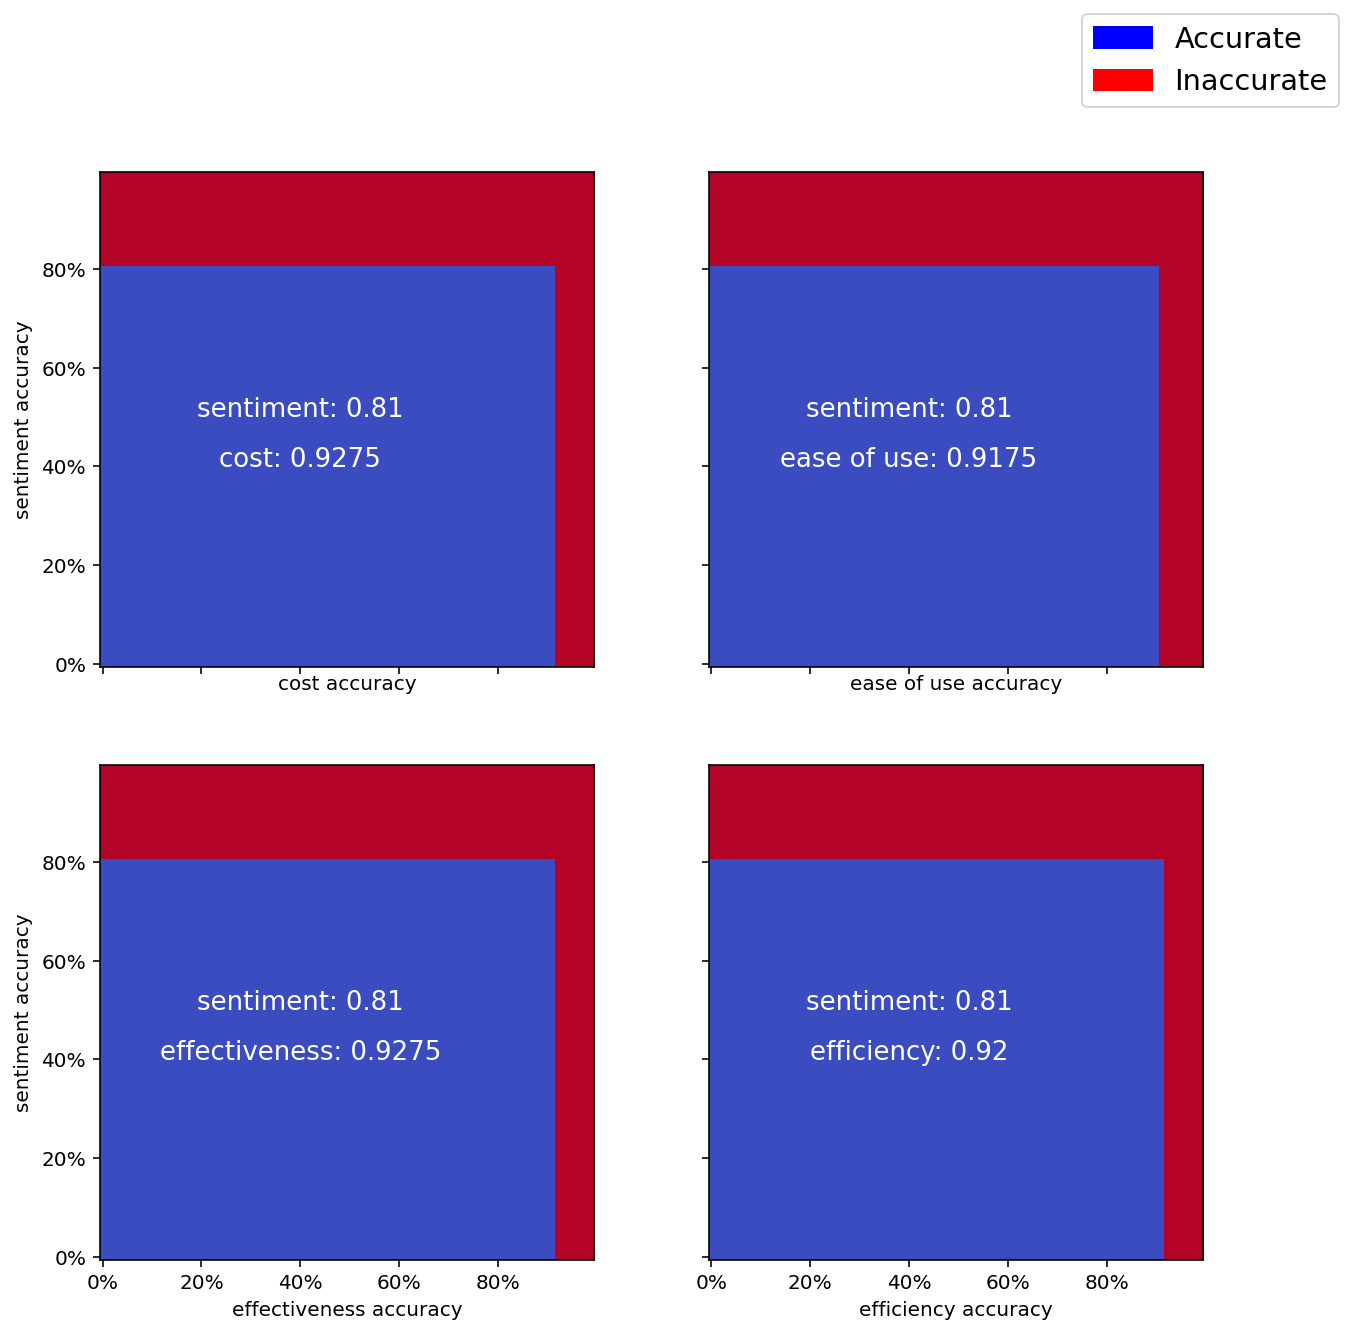

In [147]:
#fig, ax = plt.subplots()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)

fig.set_figheight(10)
fig.set_figwidth(10)

img1 = ax1.imshow(accuracy_matrix('cost'),cmap='coolwarm',origin='lower')
img2 = ax2.imshow(accuracy_matrix('ease of use'),cmap='coolwarm',origin='lower')
img3 = ax3.imshow(accuracy_matrix('effectiveness'),cmap='coolwarm',origin='lower')
img4 = ax4.imshow(accuracy_matrix('efficiency'),cmap='coolwarm',origin='lower')

img1=plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
img1=plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())


ax1.set_xlabel('cost accuracy')
ax1.set_ylabel('sentiment accuracy')
ax3.set_ylabel('sentiment accuracy')
ax2.set_xlabel('ease of use accuracy')
ax3.set_xlabel('effectiveness accuracy')
ax4.set_xlabel('efficiency accuracy')

ax1.text(40, 50, 'sentiment: '+ str(report_sentiment['accuracy']), fontsize=13, c='white',ha='center')
ax2.text(40, 50, 'sentiment: '+ str(report_sentiment['accuracy']), fontsize=13, c='white',ha='center')
ax3.text(40, 50, 'sentiment: '+ str(report_sentiment['accuracy']), fontsize=13, c='white',ha='center')
ax4.text(40, 50, 'sentiment: '+ str(report_sentiment['accuracy']), fontsize=13, c='white',ha='center')

ax1.text(40, 40, accuracy('cost')[0] +': ' +str(accuracy('cost')[1]), fontsize=13, c='white',ha='center')
ax2.text(40, 40, accuracy('ease of use')[0] +': ' +str(accuracy('ease of use')[1]), fontsize=13, c='white',ha='center')
ax3.text(40, 40, accuracy('effectiveness')[0] +': ' +str(accuracy('effectiveness')[1]), fontsize=13,c='white', ha='center')
ax4.text(40, 40, accuracy('efficiency')[0] +': ' +str(accuracy('efficiency')[1]), fontsize=13,c='white', ha='center')

blue_patch = mpatches.Patch(color='blue', label='Accurate')
red_patch = mpatches.Patch(color='red', label='Inaccurate')
fig.legend(handles=[blue_patch, red_patch],loc='upper right',fontsize='x-large')
